# Title

In [1]:
import pandas as pd
import numpy as np
import tqdm
import nltk
import time
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image

# Load Data and Preprocess

In [2]:
df = pd.read_csv('messages.csv')

In [3]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df['target'] = [1 if x=='spam' else 0 for  x in df.Category]


In [5]:
df.drop('Category', axis=1, inplace=True)
df.columns = ['message','target']
df_spam = df[df.target==1]
df_ham = df[df.target==0]

In [6]:
df.target.value_counts(normalize=True)

0    0.865937
1    0.134063
Name: target, dtype: float64

Baseline is 86.5%

In [7]:
X= df.message
y= df.target

# Tensorflow

In [8]:
# https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

In [9]:
import keras as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Recall, Precision

%load_ext tensorboard

In [10]:
SEQUENCE_LENGTH = 100 # the length of all sequences (number of words per sample)
EMBEDDING_SIZE = 100  # Using 100-Dimensional GloVe embedding vectors
TEST_SIZE = 0.25 # ratio of testing set

BATCH_SIZE = 64
EPOCHS = 20 # number of epochs

In [11]:
# Text tokenization - we have to do this before obtaining the word embeddings 
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

# vectorizing text, turning each text into sequence of integers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
# lets dump it to a file, so we can use it in testing
# pickle.dump(tokenizer, open("results/tokenizer.pickle", "wb"))
# convert to sequence of integers
X = tokenizer.texts_to_sequences(X)

In [12]:
len(X)

5572

In [13]:
# convert to numpy arrays
X = np.array(X)
y = np.array(y)
# pad sequences at the beginning of each sequence with 0's
# for example if SEQUENCE_LENGTH=4:
# [[5, 3, 2], [5, 1, 2, 3], [3, 4]]
# will be transformed to:
# [[0, 5, 3, 2], [5, 1, 2, 3], [0, 0, 3, 4]]
X = pad_sequences(X, maxlen=SEQUENCE_LENGTH)

/var/folders/1h/l422441d07d4l2q1nfyrjk740000gn/T/ipykernel_56409/1587930304.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)


In [14]:
print(X.shape)

(5572, 100)


In [15]:
X

array([[   0,    0,    0, ...,   58, 4427,  144],
       [   0,    0,    0, ...,  472,    6, 1940],
       [   0,    0,    0, ...,  660,  391, 2994],
       ...,
       [   0,    0,    0, ...,  107,  250, 9003],
       [   0,    0,    0, ...,  198,   12,   47],
       [   0,    0,    0, ...,    2,   61,  267]], dtype=int32)

In [16]:
# One Hot encoding labels
# [spam, ham, spam, ham, ham] has been converted to:
# [1, 0, 1, 0, 1] and now to:
# [[0, 1], [1, 0], [0, 1], [1, 0], [0, 1]] 
# using to_categorical()

# y = [ label2int[label] for label in y ]
# y = to_categorical(y)

In [17]:
# split and shuffle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=7)
# print our data shapes
print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)
print("y_train.shape:", y_train.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (4179, 100)
X_test.shape: (1393, 100)
y_train.shape: (4179,)
y_test.shape: (1393,)


In [18]:
# https://machinelearningmastery.com/what-are-word-embeddings/
# https://nlp.stanford.edu/projects/glove/
def get_embedding_vectors(tokenizer, dim=100):
    embedding_index = {}
    with open(f"../data/glove.6B.{dim}d.txt", encoding='utf8') as f:
        for line in tqdm.tqdm(f, "Reading GloVe"):
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = vectors

    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((len(word_index)+1, dim))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # words not found will be 0s
            embedding_matrix[i] = embedding_vector
            
    return embedding_matrix

In [19]:
import tensorflow as tf
from tensorflow import keras

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')] # precision-recall curve

2022-03-23 11:36:36.908331: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
# def get_model(tokenizer, lstm_units):
#     """
#     Constructs the model,
#     Embedding vectors => LSTM => 2 output Fully-Connected neurons with softmax activation
#     """
#     # get the GloVe embedding vectors
#     embedding_matrix = get_embedding_vectors(tokenizer)
#     # we're going to define the model sequentially https://machinelearningmastery.com/keras-functional-api-deep-learning
#     model = Sequential()
#     # First, embed the words using loaded GloVe
#     model.add(Embedding(len(tokenizer.word_index)+1,
#               EMBEDDING_SIZE,
#               weights=[embedding_matrix],
#               trainable=False,
#               input_length=SEQUENCE_LENGTH))
#     # Add long short-term memory units
#     model.add(LSTM(lstm_units, recurrent_dropout=0.2))
#     # Add dropout to combat overfitting
#     model.add(Dropout(0.3))
#     # Add output dense layer with softmax for 1/0 classification
#     model.add(Dense(2, activation="softmax"))
#     # compile as rmsprop optimizer
#     # aswell as with recall metric
#     model.compile(optimizer="rmsprop", 
#                   loss="categorical_crossentropy",
#                   metrics=["accuracy", 
#                            tf.keras.metrics.Precision(), 
#                            tf.keras.metrics.Recall()])

#     model.summary()
#     return model


In [21]:
def get_model(tokenizer, lstm_units):
    """
    Constructs the model,
    Embedding vectors => LSTM => 2 output Fully-Connected neurons with softmax activation
    """
    # get the GloVe embedding vectors
    embedding_matrix = get_embedding_vectors(tokenizer)
    # we're going to define the model sequentially https://machinelearningmastery.com/keras-functional-api-deep-learning
    model = Sequential()
    # First, embed the words using loaded GloVe
    model.add(Embedding(len(tokenizer.word_index)+1,
              EMBEDDING_SIZE,
              weights=[embedding_matrix],
              trainable=False,
              input_length=SEQUENCE_LENGTH))
    # Add long short-term memory units
    model.add(LSTM(lstm_units, recurrent_dropout=0.2))
    # Add dropout to combat overfitting
    model.add(Dropout(0.3))
    # Add output dense layer with softmax for 1/0 classification
    model.add(Dense(1, activation="sigmoid"))
    # compile as rmsprop optimizer
    # aswell as with recall metric
    model.compile(optimizer="rmsprop", 
                  loss="binary_crossentropy",
                  metrics=["accuracy", 
                           tf.keras.metrics.Precision(), 
                           tf.keras.metrics.Recall()])

    model.summary()
    return model


In [22]:
# constructs the model with 128 LSTM units
model = get_model(tokenizer=tokenizer, lstm_units=128)

Reading GloVe: 400001it [00:07, 50875.16it/s]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          900500    
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,017,877
Trainable params: 117,377
Non-trainable params: 900,500
_________________________________________________________________


In [23]:
# initialize our ModelCheckpoint and TensorBoard callbacks
# model checkpoint for saving best weights
model_checkpoint = ModelCheckpoint("../results/spam_classifier_{val_loss:.2f}.h5", save_best_only=True,
                                    verbose=1)
# for better visualization
tensorboard = TensorBoard(log_dir=f"logs/spam_classifier_{time.time()}", histogram_freq=1)
%tensorboard --logdir ./logs

# define model stopping criteria
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, 
                                              restore_best_weights=True)
# train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
          batch_size=BATCH_SIZE, epochs=EPOCHS,
          callbacks=[tensorboard, model_checkpoint, early_stop],
          verbose=1)
%tensorboard --logdir logs/fit

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

Epoch 1/20
66/66 [==============================] - ETA: 0s - loss: 0.1475 - accuracy: 0.9512 - precision: 0.8926 - recall: 0.7189
Epoch 1: val_loss improved from inf to 0.10945, saving model to ../results/spam_classifier_0.11.h5
66/66 [==============================] - 10s 118ms/step - loss: 0.1475 - accuracy: 0.9512 - precision: 0.8926 - recall: 0.7189 - val_loss: 0.1094 - val_accuracy: 0.9670 - val_precision: 0.8967 - val_recall: 0.8594
Epoch 2/20
66/66 [==============================] - ETA: 0s - loss: 0.0889 - accuracy: 0.9710 - precision: 0.9205 - recall: 0.8559
Epoch 2: val_loss improved from 0.10945 to 0.10583, saving model to ../results/spam_classifier_0.11.h5
66/66 [==============================] - 7s 111ms/step - loss: 0.0889 - accuracy: 0.9710 - precision: 0.9205 - recall: 0.8559 - val_loss: 0.1058 - val_accuracy: 0.9620 - val_precision: 0.9603 - val_recall: 0.7552
Epoch 3/20
66/66 [==============================] - ETA: 0s - loss: 0.0677 - accuracy: 0.9797 - precision: 0.

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

In [24]:
history.history

{'loss': [0.1475186049938202,
  0.08893705904483795,
  0.06774908304214478,
  0.057060644030570984,
  0.04846217483282089,
  0.041336726397275925,
  0.03454381972551346,
  0.03343161195516586,
  0.028506478294730186,
  0.026026498526334763,
  0.024154767394065857,
  0.02030196599662304,
  0.015636559575796127,
  0.013002240099012852,
  0.015267065726220608,
  0.011299258098006248,
  0.008436648175120354,
  0.007090295199304819,
  0.011854492127895355,
  0.0057712881825864315],
 'accuracy': [0.9511845111846924,
  0.971045732498169,
  0.9796602129936218,
  0.9832496047019958,
  0.9842067360877991,
  0.9887533187866211,
  0.9897104501724243,
  0.9901890158653259,
  0.9918640851974487,
  0.9928212761878967,
  0.9937784075737,
  0.9944962859153748,
  0.996410608291626,
  0.9966499209403992,
  0.996410608291626,
  0.9971284866333008,
  0.9968892335891724,
  0.9978463649749756,
  0.996410608291626,
  0.9978463649749756],
 'precision': [0.8926174640655518,
  0.9205426573753357,
  0.95192307233

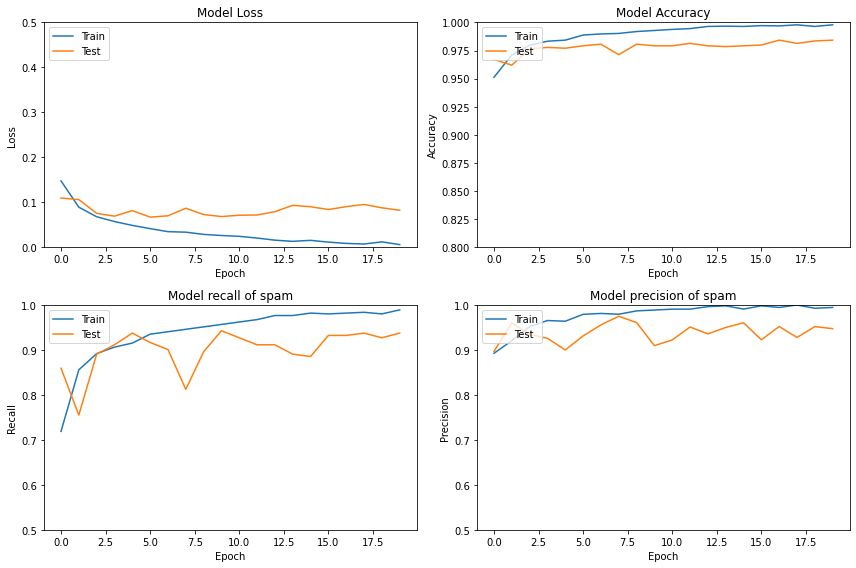

In [45]:
# Plot classification model performance metrics

fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(12,8))
ax[0,0].plot(history.history['loss'], label='Train')
ax[0,0].plot(history.history['val_loss'], label='Test')
ax[0,0].set_title('Model Loss')
ax[0,0].set_ylabel('Loss')
ax[0,0].set_ylim(0,0.5)
ax[0,0].set_xlabel('Epoch')
ax[0,0].legend(loc='upper left')
ax[0,1].plot(history.history['accuracy'], label='Train')
ax[0,1].plot(history.history['val_accuracy'], label='Test')
ax[0,1].set_title('Model Accuracy')
ax[0,1].set_ylabel('Accuracy')
ax[0,1].set_ylim(0.8,1)
ax[0,1].set_xlabel('Epoch')
ax[0,1].legend(loc='upper left')
ax[1,0].plot(history.history['recall'], label='Train')
ax[1,0].plot(history.history['val_recall'], label='Test')
ax[1,0].set_title('Model recall of spam')
ax[1,0].set_ylabel('Recall')
ax[1,0].set_ylim(0.5,1)
ax[1,0].set_xlabel('Epoch')
ax[1,0].legend(loc='upper left')
ax[1,1].plot(history.history['precision'], label='Train')
ax[1,1].plot(history.history['val_precision'], label='Test')
ax[1,1].set_title('Model precision of spam')
ax[1,1].set_ylabel('Precision')
ax[1,1].set_ylim(0.5,1)
ax[1,1].set_xlabel('Epoch')
ax[1,1].legend(loc='upper left')
plt.tight_layout()
plt.show()

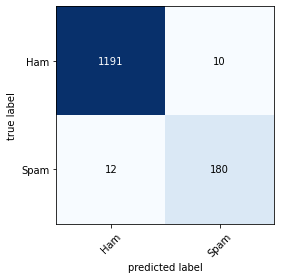

In [46]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

y_pred = (model.predict(X_test) > 0.5).astype("int32")

plot_confusion_matrix(confusion_matrix(y_test, y_pred), class_names=['Ham','Spam']);

In [27]:
# get the loss and metrics
result = model.evaluate(X_test, y_test)
# extract those
loss = result[0]
accuracy = result[1]
precision = result[2]
recall = result[3]

print(f"[+] Accuracy: {accuracy*100:.2f}%")
print(f"[+] Precision:   {precision*100:.2f}%")
print(f"[+] Recall:   {recall*100:.2f}%")

44/44 [==============================] - 1s 16ms/step - loss: 0.0822 - accuracy: 0.9842 - precision: 0.9474 - recall: 0.9375
[+] Accuracy: 98.42%
[+] Precision:   94.74%
[+] Recall:   93.75%


In [28]:
def get_predictions(text):
    sequence = tokenizer.texts_to_sequences([text])
    # pad the sequence
    sequence = pad_sequences(sequence, maxlen=SEQUENCE_LENGTH)
    # get the prediction
    prediction = model.predict(sequence)[0]
    # one-hot encoded vector, revert using np.argmax
    return int2label[np.argmax(prediction)]

In [29]:
int2label = {0: "ham", 1: "spam"}

text = "You won a prize of 1,000$, click here to claim!"
get_predictions(text)

'ham'

In [30]:
text = "Hi man, I was wondering if we can meet tomorrow."
print(get_predictions(text))

ham


In [31]:
probs = list(model.predict(X_test))
outcome = [0 if x[0]<0.5 else 1 for x in list(probs)]
dfpred = pd.DataFrame({'true': y_test,'pred':outcome})

In [32]:
dfpred

,true,pred
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
1388,0,0
1389,0,0
1390,1,1
1391,1,1


In [33]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

print(confusion_matrix(dfpred.true, dfpred.pred))
print('Accuracy',accuracy_score(dfpred.true, dfpred.pred))
print('Recall',recall_score(dfpred.true, dfpred.pred))
print('Precision',precision_score(dfpred.true, dfpred.pred))

[[1191   10]
 [  12  180]]
Accuracy 0.9842067480258435
Recall 0.9375
Precision 0.9473684210526315


[Intersting link on explaining feature importance, although I don't know how it will work with the word embedder](https://github.com/slundberg/shap#deep-learning-example-with-deepexplainer-tensorflowkeras-models)

# Nice Word Clouds

In [34]:
vectorizer = CountVectorizer(token_pattern='[A-Za-z0-9]+(?=\\s+)',
                             ngram_range=(1,2))

In [35]:
vectorizer.fit(df.message)

CountVectorizer(ngram_range=(1, 2), token_pattern='[A-Za-z0-9]+(?=\\s+)')

In [36]:
# count word appearances
def word_counter(mat):
    count = np.array(mat.sum(axis=0))[0]
    return count

In [37]:
# sort words by frequency
from operator import itemgetter

def word_frequency_sorter(words, counts):
    sort_result = sorted(zip(words, list(counts)),
                         key=itemgetter(1), reverse=True)
    return sort_result

In [38]:
stop = stopwords.words('english')

# Series text column
tvec = TfidfVectorizer(stop_words = stop,
                       ngram_range = (1, 2),
                       max_features = 1000,
                       token_pattern = '[A-Za-z0-9]+(?=\\s+)',
                        )

# Fit vectorizer on text data
tvec.fit(df.message)

# Transform data
tvec_mat = tvec.transform(df.message)

# words occuring
words = tvec.get_feature_names_out()

# count word appearances
csum= word_counter(tvec_mat)

In [39]:
# sort words by frequency
df_word_frequency = pd.DataFrame(word_frequency_sorter(
    words, csum), columns=["word", "frequency_series"])
df_word_frequency.set_index('word', inplace=True)
df_word_frequency.index.name = None
df_word_frequency.head(20)

,frequency_series
u,202.879967
call,147.794835
get,113.840056
2,97.044550
ur,92.282646
come,86.105870
like,84.654699
got,83.499020
go,79.663331
know,75.688012


There are 453387 unique words in all the descriptions.


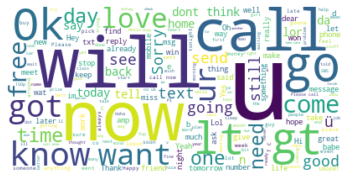

In [40]:
# all description text
wrds_cnt = " ".join(wrds for wrds in df.message)
print ("There are {} unique words in all the descriptions.".format(len(wrds_cnt)))

# create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["cnt","cnt"])

# create word cloud
wc_all = WordCloud(stopwords=stopwords,
                                  max_words=200,
                                  background_color="white")

# generate a word cloud image
wc_all.generate(wrds_cnt)

# display the generated image
plt.imshow(wc_all, interpolation='bilinear')
plt.axis("off")
plt.show()

There are 103824 unique words in all the descriptions.


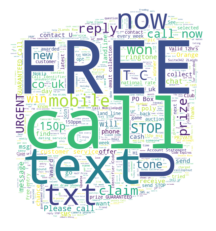

In [41]:
# all description text
wrds_cnt = " ".join(wrds for wrds in df_spam.message)
print ("There are {} unique words in all the descriptions.".format(len(wrds_cnt)))

# create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["cnt","cnt"])

# create word mask

mask_spam = np.array(Image.open('images/spam2.png'))

# create word cloud
wc_spam = WordCloud(stopwords=STOPWORDS,
               mask=mask_spam, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42, width=mask_spam.shape[1],
               height=mask_spam.shape[0])
wc_spam.generate(wrds_cnt)

# plot word cloud
plt.imshow(wc_spam, interpolation="bilinear")
plt.axis('off')
plt.show()

There are 349562 unique words in all the descriptions.


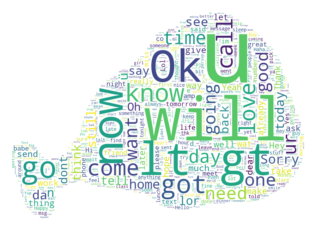

In [42]:
# all description text
wrds_cnt = " ".join(wrds for wrds in df_ham.message)
print ("There are {} unique words in all the descriptions.".format(len(wrds_cnt)))

# create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["cnt","cnt"])

# create word mask

mask_ham = np.array(Image.open('images/ham2.png'))

# create word cloud
wc_ham = WordCloud(stopwords=STOPWORDS,
               mask=mask_ham, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42, width=mask_ham.shape[1],
               height=mask_ham.shape[0])
wc_ham.generate(wrds_cnt)

# plot word cloud
plt.imshow(wc_ham, interpolation="bilinear")
plt.axis('off')
plt.show()

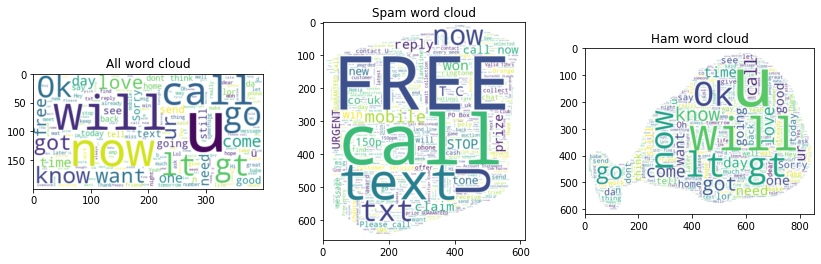

In [43]:
# combine all wordcloud plots
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14,4))
ax[0].imshow(wc_all, interpolation="bilinear")
ax[0].set_title('All word cloud')
ax[1].imshow(wc_spam, interpolation="bilinear")
ax[1].set_title('Spam word cloud')
ax[2].imshow(wc_ham, interpolation="bilinear")
ax[2].set_title('Ham word cloud')
plt.show()